In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from s

Cargar y limpiar datos

In [17]:
housing = pd.read_csv(r'C:\Users\ppmel\OneDrive\Escritorio\ITESO 6to Semestre\Lab. Aprendizaje Estadistico\Dataset\housing.csv')
housing = pd.get_dummies(housing, drop_first=True)
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean())
target = 'median_house_value'
X = housing.copy().drop(target, axis=1)
y = housing[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [19]:
# Ejempolo gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

model= GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)

model.fit(X_train, y_train)

predicciones= model.predict(X_test)
r2_score(y_true=y_test,y_pred= predicciones)

0.8198264597968716

In [20]:
## Cross validation 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline= Pipeline([
    ('gbt', GradientBoostingRegressor(n_estimators=300))
])

params= {
    'gbt__max_depth': [2,3,4,5],
    'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt= GridSearchCV(estimator=pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='r2').fit(X_train, y_train)

grid_gbt.best_estimator_.named_steps['gbt']

In [21]:
# Mejor estimador

grid_gbt.best_params_

{'gbt__learning_rate': 0.1, 'gbt__max_depth': 5}

In [23]:
# r2 score
best_model= grid_gbt.best_estimator_.named_steps['gbt']

predicciones= best_model.predict(X_test)

r2_score(y_true=y_test, y_pred=predicciones)

0.8258520500501746

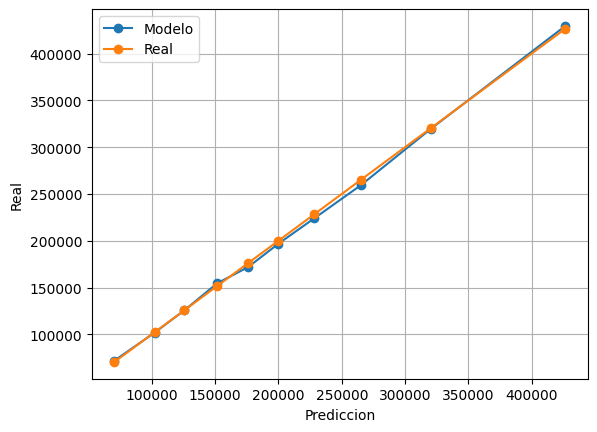

In [25]:
## Calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

calibracion(predicciones, y_test, 10)

In [28]:
# Entendiendo el modelo 
importancia = pd.DataFrame({
    'features': X_train.keys(),
    'importancia': best_model.feature_importances_
})

importancia.sort_values('importancia')

,features,importancia
9,ocean_proximity_ISLAND,0.000143
10,ocean_proximity_NEAR BAY,0.002147
11,ocean_proximity_NEAR OCEAN,0.006266
6,households,0.011899
3,total_rooms,0.014818
4,total_bedrooms,0.026551
5,population,0.034127
2,housing_median_age,0.044289
1,latitude,0.082584
0,longitude,0.100545


    PartialDependenceDisplay.from_estimator(
        best_grid_gbt,
        X_train,
        [i],
        feature_names=X_train.columns
    )

longitude


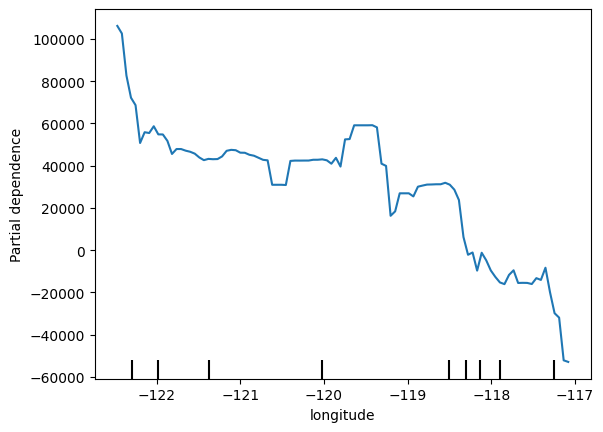

latitude


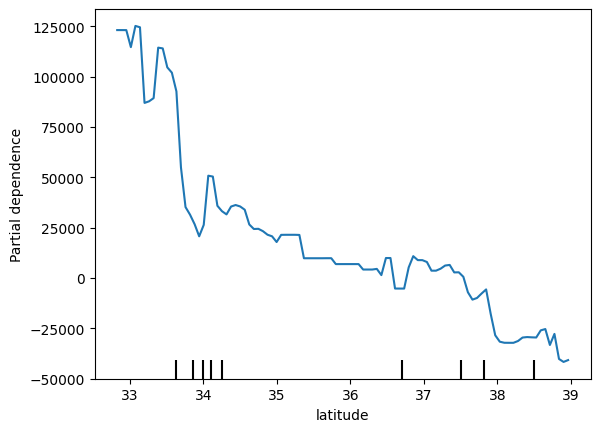

housing_median_age


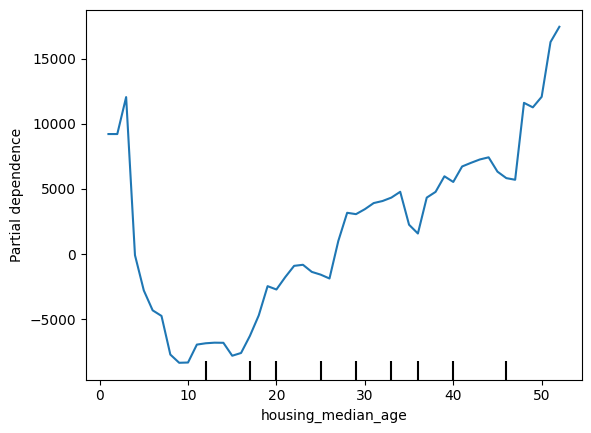

total_rooms


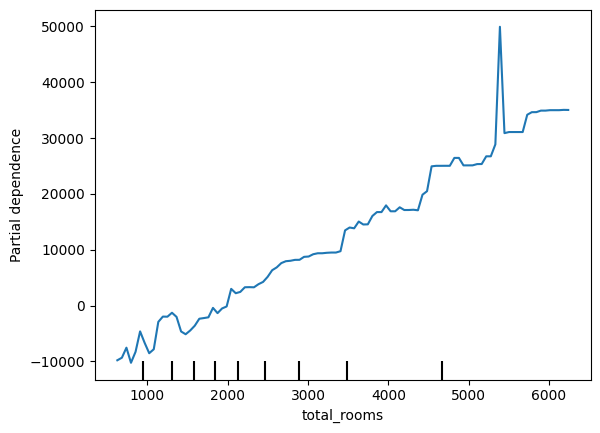

total_bedrooms


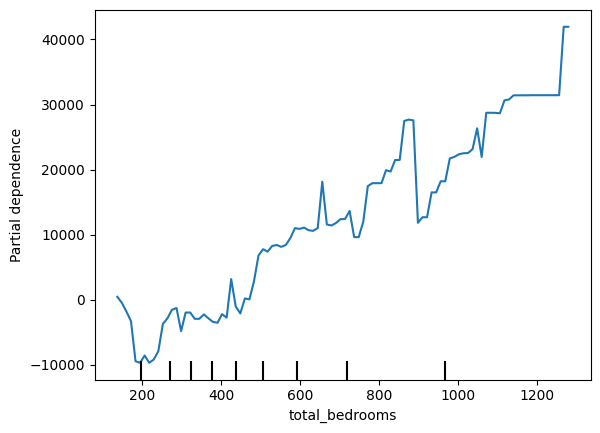

population


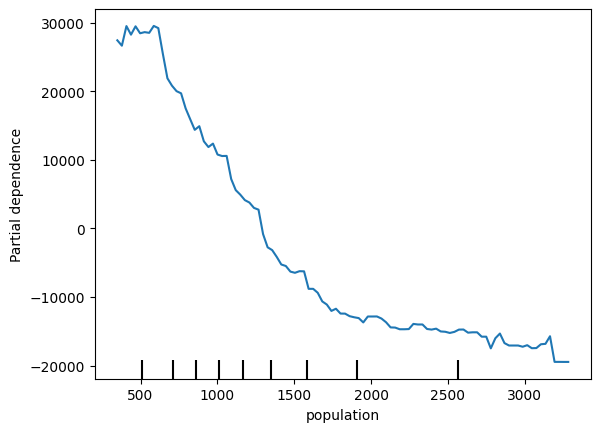

households


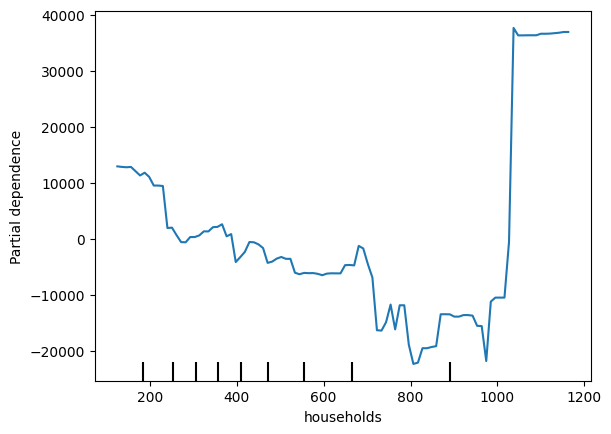

median_income


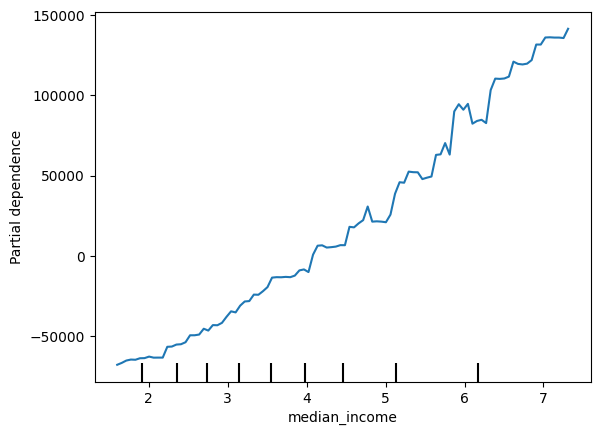

ocean_proximity_INLAND


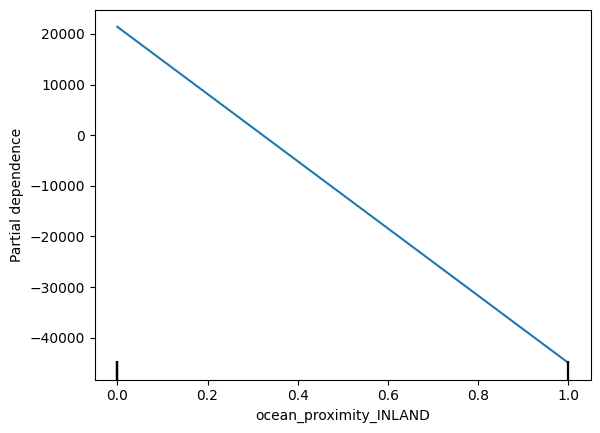

ocean_proximity_ISLAND


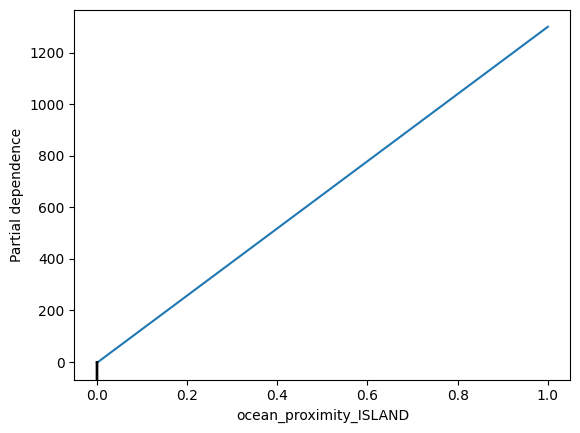

ocean_proximity_NEAR BAY


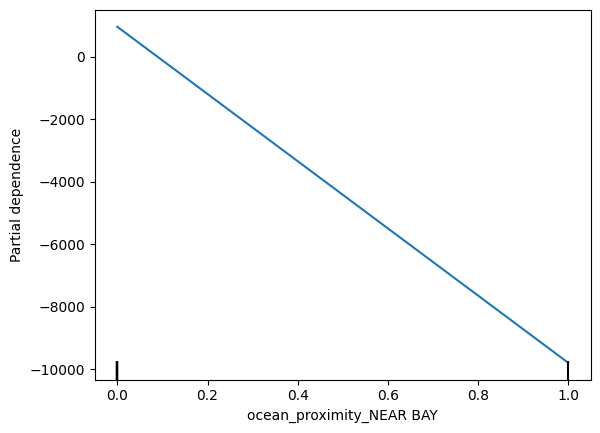

ocean_proximity_NEAR OCEAN


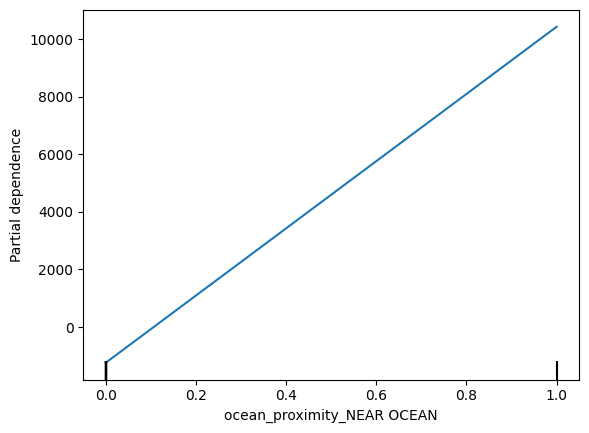

In [30]:
# Codigo for para partial dependence plot 

from sklearn.inspection import PartialDependenceDisplay


for i in range(len(X_train.keys())):
    print(X_train.keys()[i])
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        [i],
        feature_names=X_train.keys()
    )
    plt.show()